In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import pandas as pd
from collections import Counter
import seaborn as sns

In [4]:
with open('./data/flip_simple.json', 'r') as f:
    data = json.load(f)

resolution = data['resolution']
frames = data['frames']

# Define the function to get cell type name from the integer value
def getFromType(type):
    match type:
        case 0:
            return "TypeNone"
        case 1:
            return "TypeFluid"
        case 2:
            return "TypeObstacle"
        case 4: 
            return "TypeEmpty"
        case 8:
            return "TypeInflow"
        case 16:
            return "TypeOutflow"
        case 32:
            return "TypeOpen"
        case 64:
            return "TypeStick"
    return "InternalType"

# Part 1: Visualize the first frame
frame = frames[0]
particles = frame['particles']
flags = frame['flags']

# Extract particle positions
particle_positions = np.array([p['pos'] for p in particles])

# Create a figure to visualize the scene
plt.figure(figsize=(12, 10))

# Draw the grid cells with their types
cell_size = 1.0
grid_height = len(flags)
grid_width = len(flags[0])

# Convert the flags grid to a 2D numpy array for easier processing
flags_array = np.array(flags)

# Create a colormap for different cell types
cell_types = np.unique(flags_array)
type_names = [getFromType(t) for t in cell_types]
print(f"Unique cell types in the grid: {list(zip(cell_types, type_names))}")

# Draw the grid with proper colors
for y in range(grid_height):
    for x in range(grid_width):
        cell_type = flags[y][x]
        color = 'lightgray' if cell_type == 2 else 'white'  # TypeObstacle is gray, others white
        alpha = 0.3 if cell_type == 2 else 0.1
        rect = patches.Rectangle((x*cell_size, y*cell_size), cell_size, cell_size, 
                                 linewidth=1, edgecolor='black', facecolor=color, alpha=alpha)
        plt.gca().add_patch(rect)

# Draw the particles
plt.scatter(particle_positions[:, 0], particle_positions[:, 1], s=10, c='blue', alpha=0.7)

plt.title(f"Particle Scene - Frame 0 (Resolution: {resolution})")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(0, grid_width * cell_size)
plt.ylim(0, grid_height * cell_size)
plt.show()

JSONDecodeError: Extra data: line 1 column 68503169 (char 68503168)

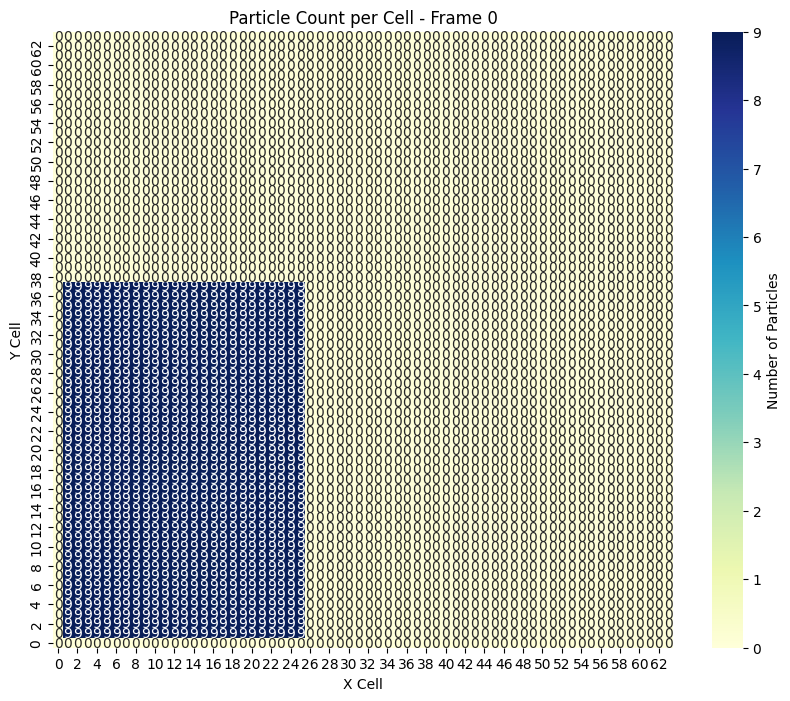


Particle distribution statistics for all cells:
Average: 2.03
Median: 0.00
Min: 0.00
Max: 9.00
Total Particles: 8325.00

Particle distribution statistics for TypeFluid cells:
Average: 9.00
Median: 9.00
Min: 9.00
Max: 9.00
Total Particles: 8325.00


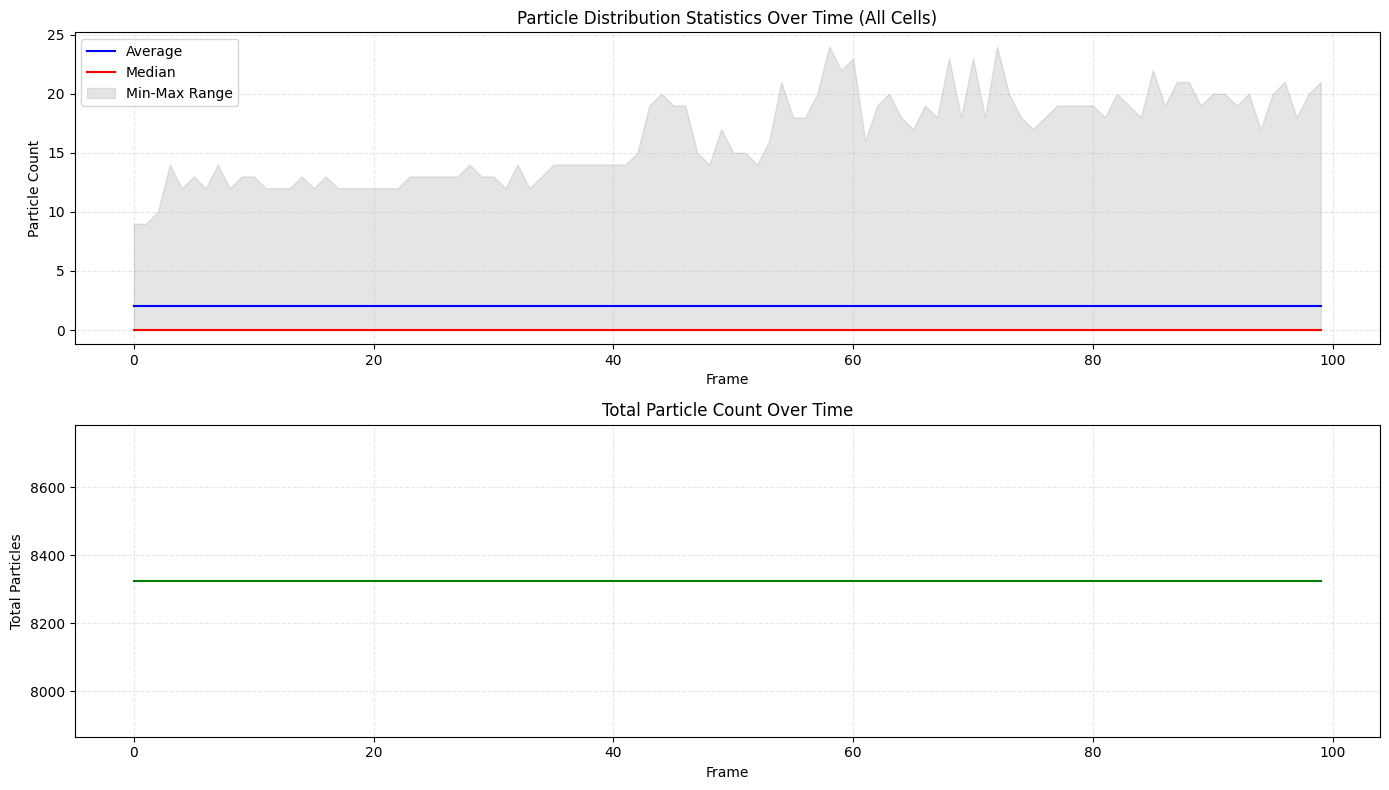

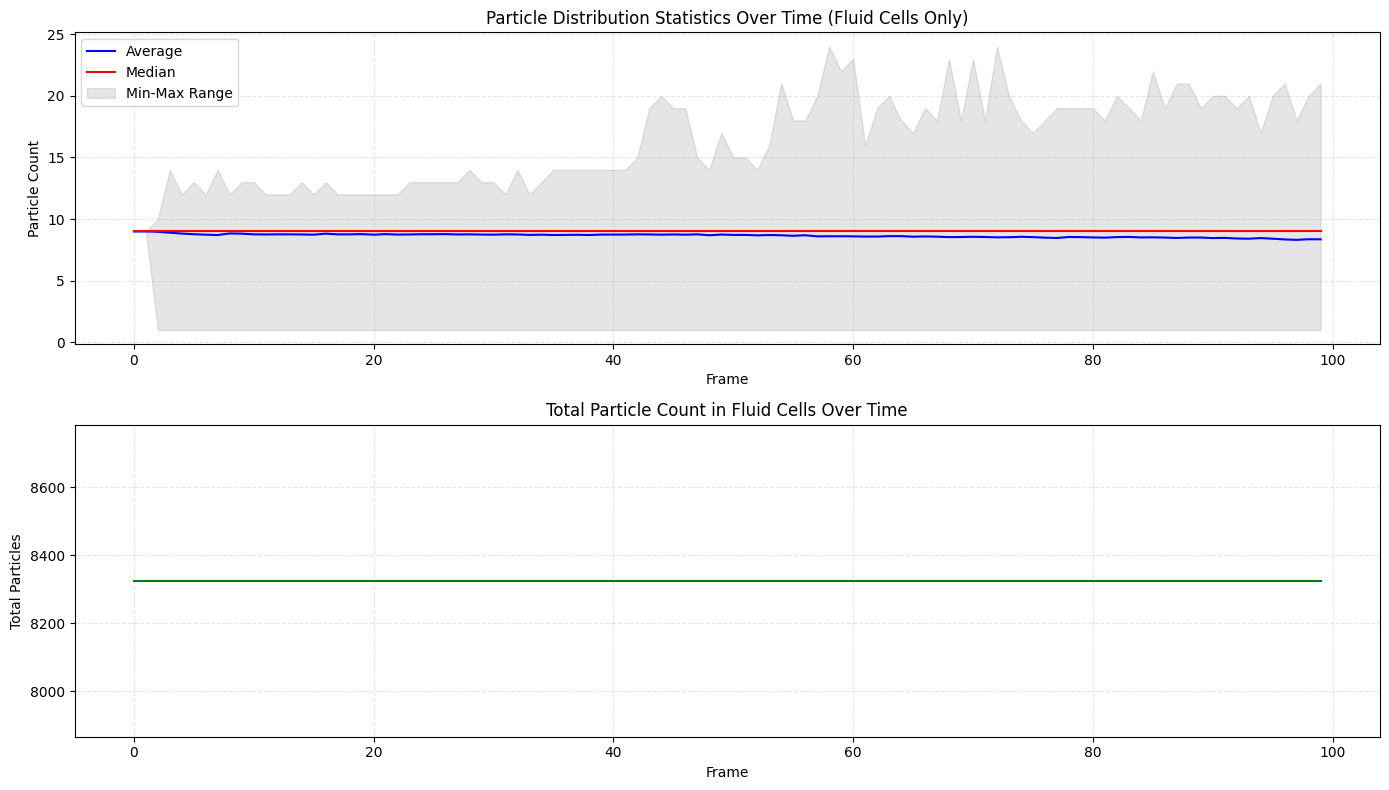

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


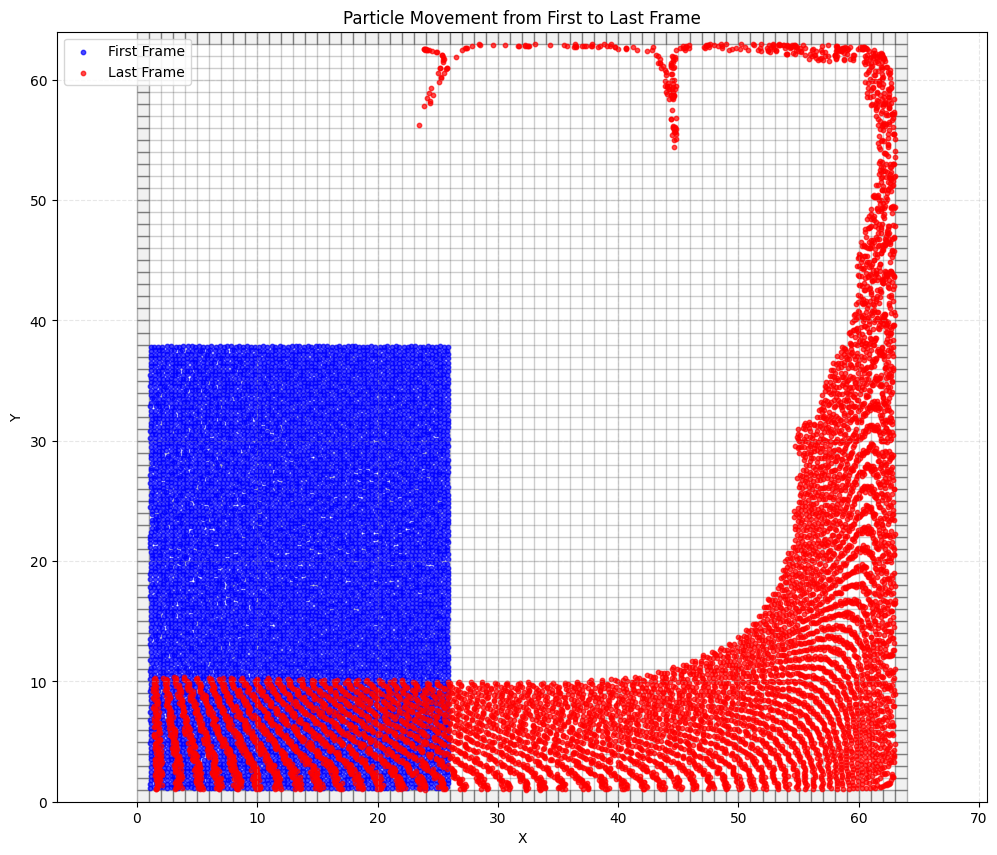

In [14]:
# Function to count particles in each cell
def count_particles_in_cells(particles, grid_width, grid_height, cell_size=1.0):
    # Initialize a 2D grid with zeros
    particle_counts = np.zeros((grid_height, grid_width), dtype=int)
    
    # Count particles in each cell
    for p in particles:
        pos = p['pos']
        # Convert position to grid coordinates
        x_cell = int(pos[0] / cell_size)
        y_cell = int(pos[1] / cell_size)
        
        # Ensure the position is within the grid bounds
        if 0 <= x_cell < grid_width and 0 <= y_cell < grid_height:
            particle_counts[y_cell, x_cell] += 1
    
    return particle_counts

# Count particles in each cell for the first frame
particle_counts = count_particles_in_cells(particles, grid_width, grid_height)

# Create a heatmap of particle distribution
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(particle_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Particles'})
heatmap.invert_yaxis()
plt.title("Particle Count per Cell - Frame 0")
plt.xlabel("X Cell")
plt.ylabel("Y Cell")
plt.show()

# Calculate statistics for all cells
all_counts = particle_counts.flatten()
all_stats = {
    "Average": np.mean(all_counts),
    "Median": np.median(all_counts),
    "Min": np.min(all_counts),
    "Max": np.max(all_counts),
    "Total Particles": np.sum(all_counts)
}

print("\nParticle distribution statistics for all cells:")
for stat, value in all_stats.items():
    print(f"{stat}: {value:.2f}")

# Calculate statistics only for TypeFluid cells (type 1)
# Note: According to the visualization, it seems all cells are TypeObstacle (2),
# but we'll provide the calculation logic anyway
fluid_cells = np.where(flags_array == 1)
if len(fluid_cells[0]) > 0:
    fluid_counts = particle_counts[fluid_cells]
    fluid_stats = {
        "Average": np.mean(fluid_counts),
        "Median": np.median(fluid_counts),
        "Min": np.min(fluid_counts),
        "Max": np.max(fluid_counts),
        "Total Particles": np.sum(fluid_counts)
    }
    
    print("\nParticle distribution statistics for TypeFluid cells:")
    for stat, value in fluid_stats.items():
        print(f"{stat}: {value:.2f}")
else:
    print("\nNo TypeFluid cells found in the grid.")

# Part 3: Analyze how these statistics change across frames

# Initialize lists to store statistics for each frame
frame_stats = []

# Process each frame
for i, frame in enumerate(frames):
    particles = frame['particles']
    flags = frame['flags']
    flags_array = np.array(flags)
    
    # Count particles in each cell
    particle_counts = count_particles_in_cells(particles, grid_width, grid_height)
    
    # Calculate statistics for all cells
    all_counts = particle_counts.flatten()
    stats = {
        "Frame": i,
        "Average (All)": np.mean(all_counts),
        "Median (All)": np.median(all_counts),
        "Min (All)": np.min(all_counts),
        "Max (All)": np.max(all_counts),
        "Total Particles": np.sum(all_counts)
    }
    
    # Calculate statistics only for TypeFluid cells (if any)
    fluid_cells = np.where(flags_array == 1)
    if len(fluid_cells[0]) > 0:
        fluid_counts = particle_counts[fluid_cells]
        stats.update({
            "Average (Fluid)": np.mean(fluid_counts),
            "Median (Fluid)": np.median(fluid_counts),
            "Min (Fluid)": np.min(fluid_counts),
            "Max (Fluid)": np.max(fluid_counts),
            "Total Particles (Fluid)": np.sum(fluid_counts)
        })
    
    frame_stats.append(stats)

# Convert to DataFrame for easier analysis
stats_df = pd.DataFrame(frame_stats)

# Plot how statistics change over frames
plt.figure(figsize=(14, 8))

# Plot average and median for all cells
plt.subplot(2, 1, 1)
plt.plot(stats_df['Frame'], stats_df['Average (All)'], 'b-', label='Average')
plt.plot(stats_df['Frame'], stats_df['Median (All)'], 'r-', label='Median')
plt.fill_between(stats_df['Frame'], stats_df['Min (All)'], stats_df['Max (All)'], 
                 color='gray', alpha=0.2, label='Min-Max Range')
plt.title("Particle Distribution Statistics Over Time (All Cells)")
plt.xlabel("Frame")
plt.ylabel("Particle Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Plot total particle count
plt.subplot(2, 1, 2)
plt.plot(stats_df['Frame'], stats_df['Total Particles'], 'g-', label='Total Particles')
plt.title("Total Particle Count Over Time")
plt.xlabel("Frame")
plt.ylabel("Total Particles")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# If there are fluid cells, plot statistics for them as well
if 'Average (Fluid)' in stats_df.columns:
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(stats_df['Frame'], stats_df['Average (Fluid)'], 'b-', label='Average')
    plt.plot(stats_df['Frame'], stats_df['Median (Fluid)'], 'r-', label='Median')
    plt.fill_between(stats_df['Frame'], stats_df['Min (Fluid)'], stats_df['Max (Fluid)'], 
                     color='gray', alpha=0.2, label='Min-Max Range')
    plt.title("Particle Distribution Statistics Over Time (Fluid Cells Only)")
    plt.xlabel("Frame")
    plt.ylabel("Particle Count")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(stats_df['Frame'], stats_df['Total Particles (Fluid)'], 'g-', 
             label='Total Particles in Fluid Cells')
    plt.title("Total Particle Count in Fluid Cells Over Time")
    plt.xlabel("Frame")
    plt.ylabel("Total Particles")
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Additional analysis: Visualize particle movement between frames
if len(frames) > 1:
    first_frame = frames[0]
    last_frame = frames[-1]
    
    first_positions = np.array([p['pos'] for p in first_frame['particles']])
    last_positions = np.array([p['pos'] for p in last_frame['particles']])
    
    plt.figure(figsize=(12, 10))
    
    # Draw the grid
    for y in range(grid_height):
        for x in range(grid_width):
            cell_type = first_frame['flags'][y][x]
            color = 'lightgray' if cell_type == 2 else 'white'
            alpha = 0.3 if cell_type == 2 else 0.1
            rect = patches.Rectangle((x*cell_size, y*cell_size), cell_size, cell_size, 
                                     linewidth=1, edgecolor='black', facecolor=color, alpha=alpha)
            plt.gca().add_patch(rect)
    
    # Draw particles from first frame in blue and last frame in red
    plt.scatter(first_positions[:, 0], first_positions[:, 1], s=10, c='blue', alpha=0.7, label='First Frame')
    plt.scatter(last_positions[:, 0], last_positions[:, 1], s=10, c='red', alpha=0.7, label='Last Frame')
    
    plt.title(f"Particle Movement from First to Last Frame")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim(0, grid_width * cell_size)
    plt.ylim(0, grid_height * cell_size)
    plt.legend()
    plt.show()